In [1]:
import os
import numpy as np
import sys
import json
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

     size  count  root  time-o  algbw-o  busbw-o  numwrongo  time-i  algbw-i  \
0   32768     64    -1   770.9     0.04     0.04          0   747.4     0.04   
1   65536    128    -1   724.9     0.09     0.09          0   748.5     0.09   
2  131072    256    -1   753.8     0.17     0.17          0   752.7     0.17   
3  262144    512    -1   805.2     0.33     0.32          0   798.6     0.33   
4  524288   1024    -1   884.9     0.59     0.59          0   884.2     0.59   

   busbw-i  numwrongi  num_nodes  gpus_per_node         op  
0     0.04          0        128              1  allgather  
1     0.09          0        128              1  allgather  
2     0.17          0        128              1  allgather  
3     0.33          0        128              1  allgather  
4     0.59          0        128              1  allgather  
32
nodes = 8, gpus_per_node = 4
32
nodes = 16, gpus_per_node = 2


<Figure size 1500x1200 with 0 Axes>

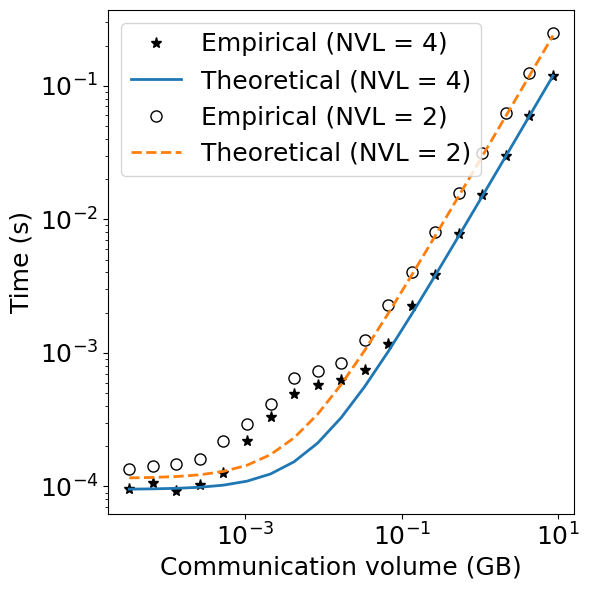

In [2]:
''' NCCL tests output in sample_data; plot theoretical times vs empirical 
    sample_data gives the op, comm size, times and bandwidths of nccl tests
    on Perlmutter. Print the DF to see the info
    Then we compute theoretical times for the same using hardware specs from
    Perlmutter and compare the two'''

df = pd.read_pickle('sample_data.pkl')
print(df.head())

### 4 GPUs per node 
op = 'allgather'
gpus_per_node = 4
nodes = 8
n = nodes * gpus_per_node
print(n)
plt.figure(figsize=(15, 12))

bw = df.loc[(df['op'] == op) & (df['num_nodes'] == nodes) & (df['gpus_per_node'] == gpus_per_node)]
fig, ax = plt.subplots(1, 1, figsize=(6,6))
sz_arr = bw['size'] * 1e-9
t_emp = 0.5 * (bw['time-o'] + bw['time-i']) * 1e-6
ax.plot(sz_arr, t_emp, '*', color='black', markersize=8)
ax.set_xscale('log')
ax.set_yscale('log')

es = 0.7
ef = 0.7
ibc = 1
nvc = (gpus_per_node - 1)

bs = 25 * es * ibc
bf = 100 * ef * nvc
ls = 5 * 1e-6
lf = 2.5 * 1e-6

t = []
for sz in sz_arr:
    t1 = sz / (gpus_per_node * bs) if nodes > 1 else 0
    t2 = sz / bf if bf != 0 else 0
    t_comm = (n - 1)/n * max(t1, t2)
    t_comm += ls * (nodes - 1) + lf * (n - nodes)
    t.append(t_comm)

print('nodes = {}, gpus_per_node = {}'.format(nodes, gpus_per_node))
ax.plot(sz_arr, t, linewidth=2, linestyle='-')
ax.set_xlabel('Communication volume (GB)', fontsize=18)
ax.set_ylabel('Time (s)', fontsize=18)


### 2 GPUs per node 
#########
op = 'allgather'
gpus_per_node = 2
nodes = 16
n = nodes * gpus_per_node
print(n)

bw = df.loc[(df['op'] == op) & (df['num_nodes'] == nodes) & (df['gpus_per_node'] == gpus_per_node)]
sz_arr = bw['size'] * 1e-9
t_emp = 0.5 * (bw['time-o'] + bw['time-i']) * 1e-6
ax.plot(sz_arr, t_emp, 'o', color='black', fillstyle='none', markersize=8)
ax.set_xscale('log')
ax.set_yscale('log')

es = 0.7
ef = 0.7
ibc = 1
nvc = (gpus_per_node - 1)

bs = 25 * es * ibc
bf = 100 * ef * nvc
ls = 5 * 1e-6
lf = 2.5 * 1e-6

t = []
for sz in sz_arr:
    t1 = sz / (gpus_per_node * bs) if nodes > 1 else 0
    t2 = sz / bf if bf != 0 else 0
    t_comm = (n - 1)/n * max(t1, t2)
    t_comm += ls * (nodes - 1) + lf * (n - nodes)
    t.append(t_comm)

print('nodes = {}, gpus_per_node = {}'.format(nodes, gpus_per_node))
ax.plot(sz_arr, t, linewidth=2, linestyle='--')

ax.legend(['Empirical (NVL = 4)', 'Theoretical (NVL = 4)', 'Empirical (NVL = 2)', 'Theoretical (NVL = 2)'], fontsize=18,)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
plt.tight_layout()
# plt.savefig('comm_validation.pdf', dpi=400)